In [1]:
from bluemath_tk.predictor.xwt import XWT

daily_xwt = XWT(steps={}).load_model("outputs/dwt_model_aveiro.pkl")
dwts_to_fit = daily_xwt.steps.get("pca").pcs.kma_bmus.to_dataset(name="bmus")
dwts_to_fit["cenEOFs"] = (
    ("n_clusters", "n_features"),
    daily_xwt.steps.get("kma").kma.cluster_centers_,
)
dwts_to_fit

<xarray.Dataset> Size: 257kB
Dimensions:  (time: 19684, n_clusters: 36, n_features: 142)
Coordinates:
  * time     (time) datetime64[s] 157kB 1970-01-01 1970-01-02 ... 2023-11-22
Dimensions without coordinates: n_clusters, n_features
Data variables:
    bmus     (time) int32 79kB 21 21 21 9 9 9 9 9 1 1 ... 5 5 5 5 18 7 5 5 19 36
    cenEOFs  (n_clusters, n_features) float32 20kB -2.43 9.382 ... 0.01363

In [2]:
import xarray as xr

waves = (
    xr.open_dataset("data/era5_aveiro.nc")
    .sel(time=dwts_to_fit.time, method="nearest")
    .rename({"swh": "bulk_Hs", "pp1d": "bulk_Tp", "mwd": "bulk_Dir"})
)
waves["bmus"] = (("time"), dwts_to_fit["bmus"].values)
waves["AWL"] = waves["bulk_Hs"] ** 2 * waves["bulk_Tp"]
waves

<xarray.Dataset> Size: 866kB
Dimensions:    (time: 19684)
Coordinates:
    longitude  float32 4B ...
    latitude   float32 4B ...
  * time       (time) datetime64[ns] 157kB 1970-01-01 1970-01-02 ... 2023-11-22
Data variables:
    bulk_Hs    (time) float64 157kB 2.719 1.55 1.56 2.952 ... 2.378 3.309 3.052
    bulk_Tp    (time) float64 157kB ...
    bulk_Dir   (time) float64 157kB ...
    bmus       (time) int32 79kB 21 21 21 9 9 9 9 9 1 1 ... 5 5 5 18 7 5 5 19 36
    AWL        (time) float64 157kB 91.88 36.83 35.2 97.26 ... 72.98 81.13 78.73
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-24 23:51:43 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [3]:
from bluemath_tk.teslakit.climate_emulator import Climate_Emulator

ce = Climate_Emulator(
    "/workspaces/BlueMath/climate_services/MUSCLE.Aveiro/outputs/emulator"
)

config = {
    "waves_families": ["bulk"],
    "distribution": [],
    "do_chromosomes": False,
}
ce.FitExtremes(KMA=dwts_to_fit, WVS=waves, config=config)

Waves Families: ['bulk']
Extra Variables: []
GEV distribution: ['bulk_Hs', 'bulk_Tp']
Empirical distribution: ['bulk_Dir']
Weibull distribution: []
Do chromosomes combinations: False
Max. Storms PROXY: AWL


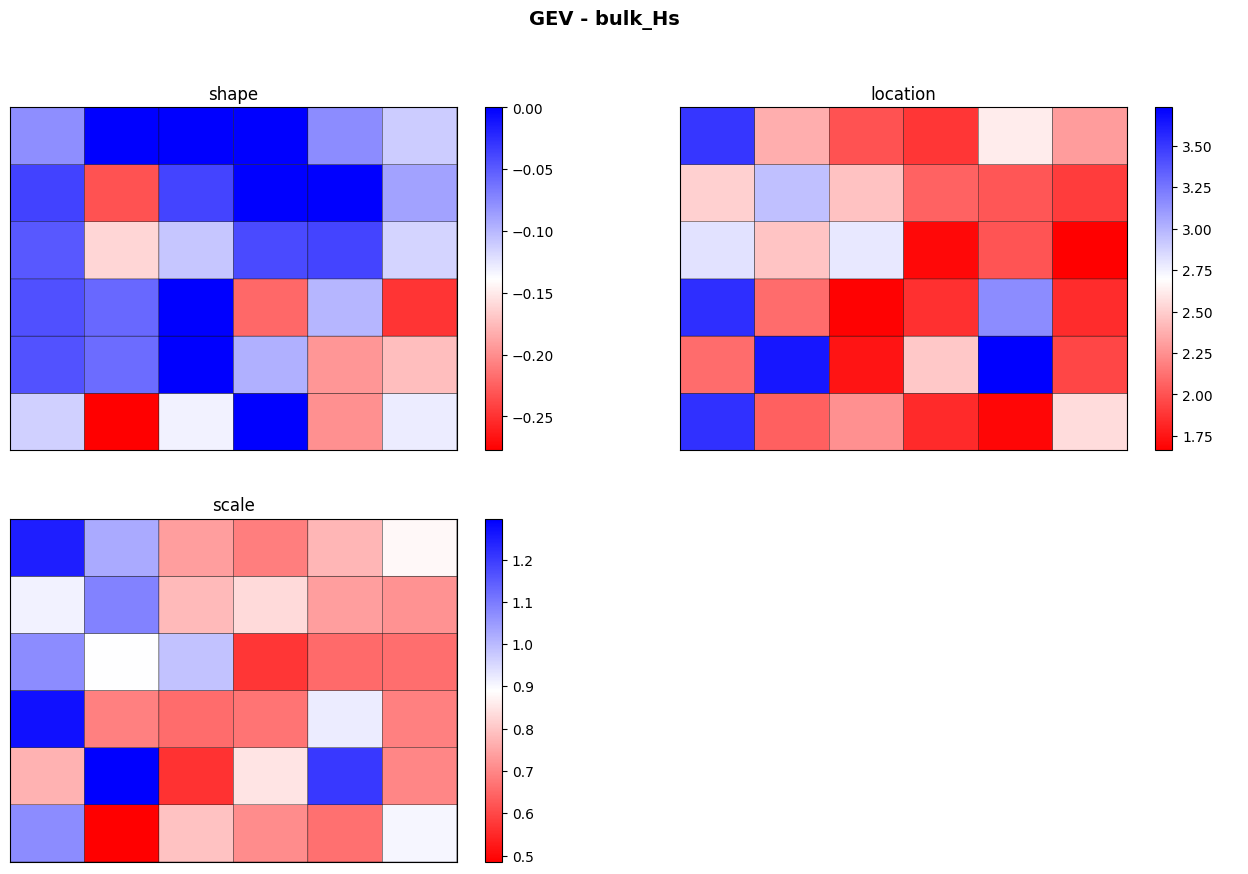

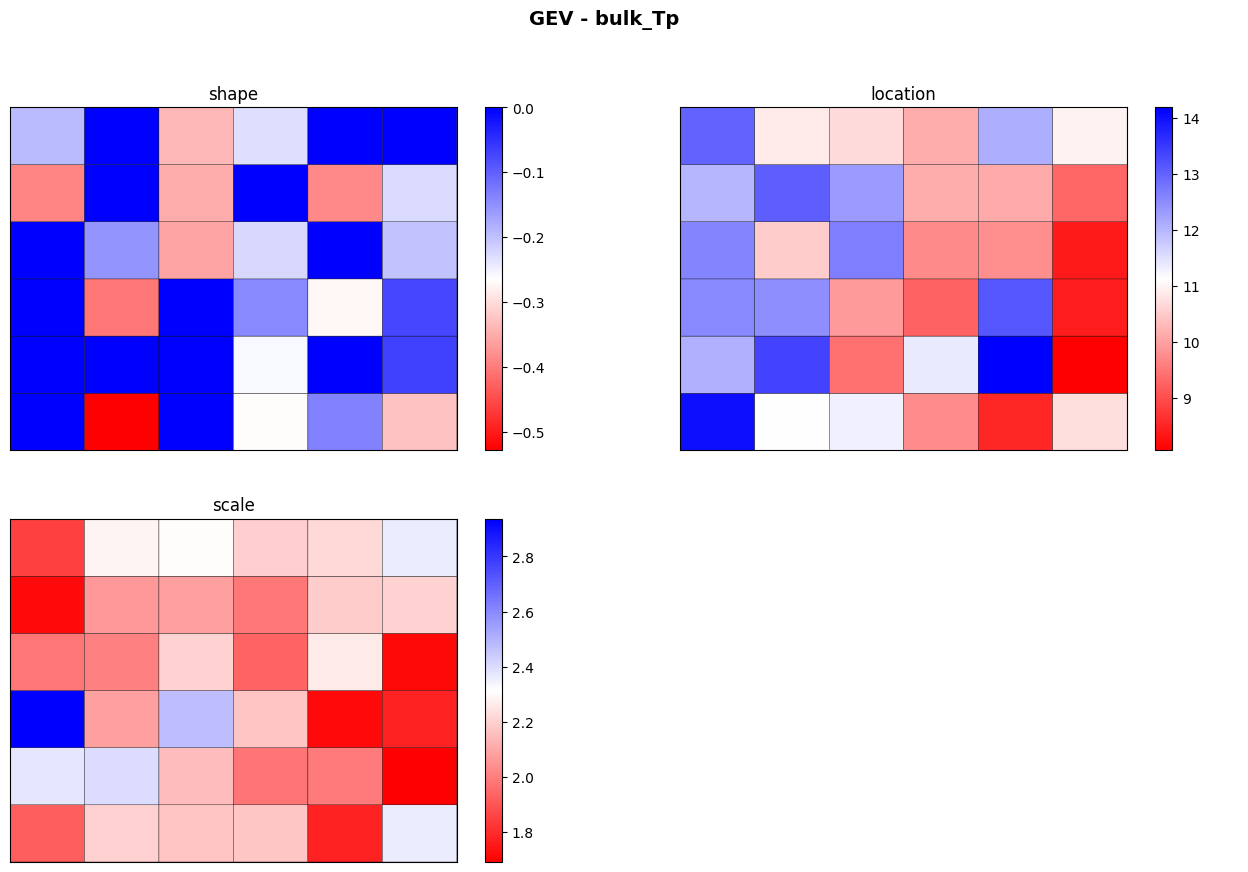

In [4]:
# Fit report figures

ce.Report_Fit(vns_GEV=["Hs", "Tp"], plot_chrom=False, plot_sigma=False);

In [5]:
# Load simulated DWTs

simulated_dwts = xr.open_dataset("outputs/dwt_alr/xds_output.nc")
simulated_dwts

<xarray.Dataset> Size: 2MB
Dimensions:      (time: 36891, n_sim: 5)
Coordinates:
  * time         (time) datetime64[ns] 295kB 1999-01-01 ... 2100-01-01
Dimensions without coordinates: n_sim
Data variables:
    evbmus_sims  (time, n_sim) float32 738kB ...
    ofbmus_sims  (time, n_sim) float32 738kB ...

In [6]:
simulated_waves = ce.Simulate_Waves(simulated_dwts.isel(n_sim=0), 1)
simulated_waves

C.E: Sim. Waves: 100%|██████████| 11903/11903 [00:40<00:00, 292.23it/s]


<xarray.Dataset> Size: 429kB
Dimensions:   (n_sim: 1, time: 11903)
Coordinates:
  * time      (time) datetime64[ns] 95kB 1999-01-01 1999-01-03 ... 2100-01-01
Dimensions without coordinates: n_sim
Data variables:
    DWT       (n_sim, time) float32 48kB 21.0 9.0 19.0 13.0 ... 17.0 3.0 14.0
    bulk_Hs   (n_sim, time) float64 95kB 1.684 1.883 1.185 ... 2.14 2.331 2.456
    bulk_Tp   (n_sim, time) float64 95kB 12.8 10.83 11.71 ... 10.88 12.38 13.71
    bulk_Dir  (n_sim, time) float64 95kB 277.0 291.6 294.2 ... 320.0 280.6 287.9

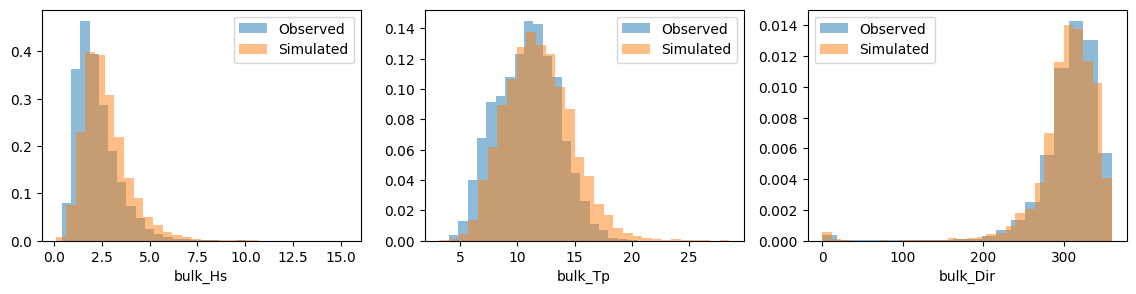

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(14, 3))
waves["bulk_Hs"].plot.hist(ax=ax[0], label="Observed", alpha=0.5, density=True, bins=20)
simulated_waves["bulk_Hs"].plot.hist(
    ax=ax[0], label="Simulated", alpha=0.5, density=True, bins=30
)
ax[0].legend()
waves["bulk_Tp"].plot.hist(ax=ax[1], label="Observed", alpha=0.5, density=True, bins=20)
simulated_waves["bulk_Tp"].plot.hist(
    ax=ax[1], label="Simulated", alpha=0.5, density=True, bins=30
)
ax[1].legend()
waves["bulk_Dir"].plot.hist(
    ax=ax[2], label="Observed", alpha=0.5, density=True, bins=20
)
simulated_waves["bulk_Dir"].plot.hist(
    ax=ax[2], label="Simulated", alpha=0.5, density=True, bins=30
)
ax[2].legend()